# Tensorflow 的可视化 Tensorboard

在上一篇notebook中，我们为大家展示了一个简单的基于Tensorflow的卷积神经网络。Tensorflow的可视化--tensorboard是tensorflow最主要的优点之一。不管多么复杂的神经网络结构，tensorboard都可以将其结构展现出来，并且标注出data的流向，tensorflow也因此得名。

今天，我们将基于上一篇的CNN code，为大家简单说明怎么应用并且调用Tensorboard.


首先，我们先看一下改过的code。绝大多数code和上一篇的CNN一样。我们会逐一将改动的地方加以说明。

In [1]:
import input_data
import tensorflow as tf

def weight_variable(shape, names):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name = names)

def bias_variable(shape, names):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = names)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
  
  
###########################################################

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

##########################################################

graphCNN = tf.Graph()
with graphCNN.as_default():

    # define x and y_
    x = tf.placeholder("float", shape=[None, 784])
    y_ = tf.placeholder("float", shape=[None, 10])
    
    x_image = tf.reshape(x, [-1,28,28,1])
      
    
    with tf.name_scope('CNN1'):
        W_conv1 = weight_variable([5, 5, 1, 32], 'weights1')
        b_conv1 = bias_variable([32], 'bias1')
    variable_summaries(W_conv1, "CNN1")
        
    with tf.name_scope('CNN1-Act'):
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)   
    tf.summary.histogram('post_activations1', h_pool1)
    
    
    with tf.name_scope('CNN2'):
        W_conv2 = weight_variable([5, 5, 32, 64], 'weights2')
        b_conv2 = bias_variable([64], 'bias2')
    variable_summaries(W_conv2, "CNN2")
        
    
    with tf.name_scope('CNN2-Act'):
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
    tf.summary.histogram('post_activations2', h_pool2)
    
    
    with tf.name_scope('FC1'):
        # 7 = 28/2/2
        W_fc1 = weight_variable([7 * 7 * 64, 1024], 'weightFC1')
        b_fc1 = bias_variable([1024], 'biasFC1')
    variable_summaries(W_fc1, "FC1")
    
    
    with tf.name_scope('FC1-Act'):
        # reshape the h_pool2 for the fully connected layer
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    tf.summary.histogram('post_activations2', h_fc1)

  
    with tf.name_scope('Dropout'):       
        keep_prob = tf.placeholder("float")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    
    
    with tf.name_scope('FC2'):
        W_fc2 = weight_variable([1024, 10], 'weightFC2')
        b_fc2 = bias_variable([10], 'biasFC2')
    variable_summaries(W_fc2, 'FC2')
    
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    with tf.name_scope('cross_entropy'):
        cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
    tf.summary.scalar('cross_entropy', cross_entropy)

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.summary.scalar('accuracy', accuracy)

    summary_op = tf.summary.merge_all()

#######################################################################


with tf.Session(graph=graphCNN) as sess:
    
    init = tf.global_variables_initializer()
    
    summary_writer = tf.summary.FileWriter("tmp/tensorflowlog", sess.graph)  # not /tmp/...
    
    sess.run(init)
    
    for i in range(1000):
        
        batch = mnist.train.next_batch(50)
        
        # notice train_step.run; trainning using keep prob 0.5
        _, summary_str = sess.run([train_step, summary_op], feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
            
        if i%100 == 0:   
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush() 
            

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## 1. 定义一个能可视化的Graph

TensorBoard 通过读取 TensorFlow 的事件文件来运行。TensorFlow 的事件文件包括了你会在 TensorFlow 运行中涉及到的主要数据。所以第一步，当我们在构建Graph的时候，需要告诉Tensorflow我们想可视化这个Graph。具体code如下：


In [ ]:
graphCNN = tf.Graph()
with graphCNN.as_default():

别忘了在随后的sess中调用这个Graph

In [ ]:
with tf.Session(graph=graphCNN) as sess:

## 2. tf.summary.scalar 和 tf.histogram_summary

在创建完你想汇总数据的 TensorFlow Graph，然后我们再选择在哪些节点进行汇总(summary)操作。

比如，假设你正在训练一个卷积神经网络，你可能希望记录学习速度(learning rate)的如何变化，以及目标函数如何变化。通过向节点附加scalar_summary操作来分别输出学习速度和期望误差。当然可以给每个scalary_summary 起一个有意义的名字，比如 'learning rate' 和 'loss function'。

如果你还希望显示一个layer中输出的分布，或者梯度权重的分布。可以通过分别附加 histogram_summary 来收集这些数据。

这里为了方便调用，我们写个一个function（如下），这个function输出每个节点的 mean，sd，max，min和distribution。

值得注意的是，我们刚才创建的这些节点（summary nodes）都围绕着Graph，没有任何操作依赖于它们的结果。

In [ ]:
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

## 3. tf.summary.merge_all

为了生成汇总信息，我们需要运行所有这些节点。这里，我们可以使用tf.merge_all_summaries。

然后，为了将汇总数据存出，我们需要将汇总的数据传递给tf.train.Summarywriter。SummaryWriter中的参数logdir非常重要，所有事件都会写到它所指的目录下。

这里需要注意，Tensorboard不区分存在同一个目录下的多次run的输出，所以我们需要为每一次run建一个sub-folder （tensorflowlog here）。


In [ ]:
summary_op = tf.summary.merge_all()
    
summary_writer = tf.summary.FileWriter("tmp/tensorflowlog", sess.graph)

## 4. summary_writer.add_summary

做好了这些准备工作之后，我们开始将汇总的数据写入我们设定好的目录下。这里，我们每100步记录一次事件参数，具体步骤如下：

In [ ]:
if i%100 == 0:   
    summary_str = sess.run(summary_op, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    summary_writer.add_summary(summary_str, i)
    summary_writer.flush()

## 5. 打开Tensorboard

好了！到目前为止我们已经将可视化的时候需要的所有数据都存了出来，接下来我们需要用Tensorboard来可视化这些数据。

首先，打开 Prompt（mac用户打开terminal）

假设我们的输出存在这个目录下：c:\Users\cxin\Documents\Tensorflow-Script\tmp\tensorflowlog

首先更改Prompt中的目录： cd /d c:\Users\cxin\Documents\Tensorflow-Script

然后，输入 tensorboard --logdir=tmp/tensorflowlog。这里需要注意，一定要确保路径的正确，否则tensorboard将无法找到我们之前存储的数据。

输入完以上指令后，你会看到：

Starting TensorBoard at http://........

然后，打开Google Chrome，进入 http://........ 



## 6. How does it look like?

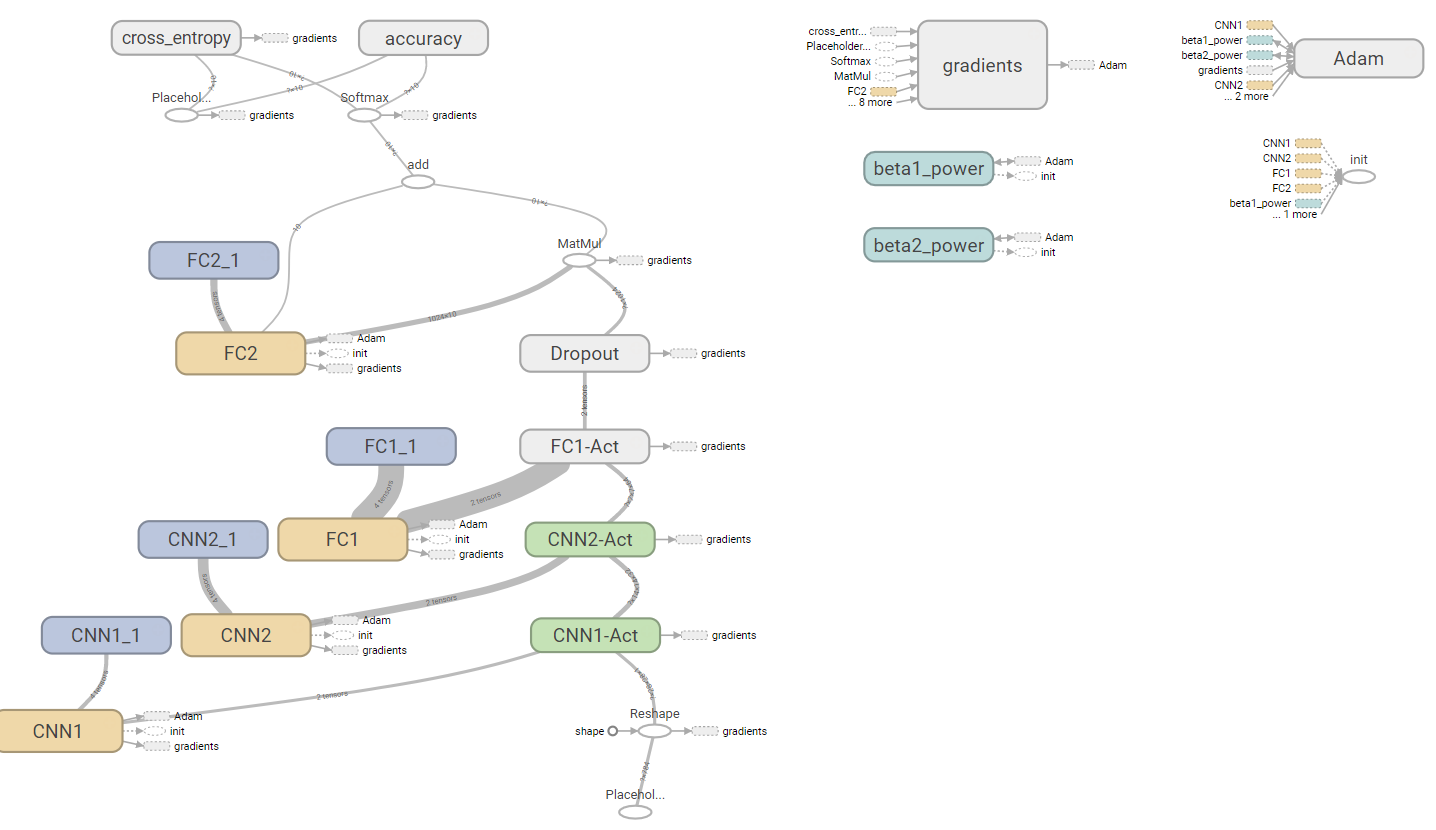

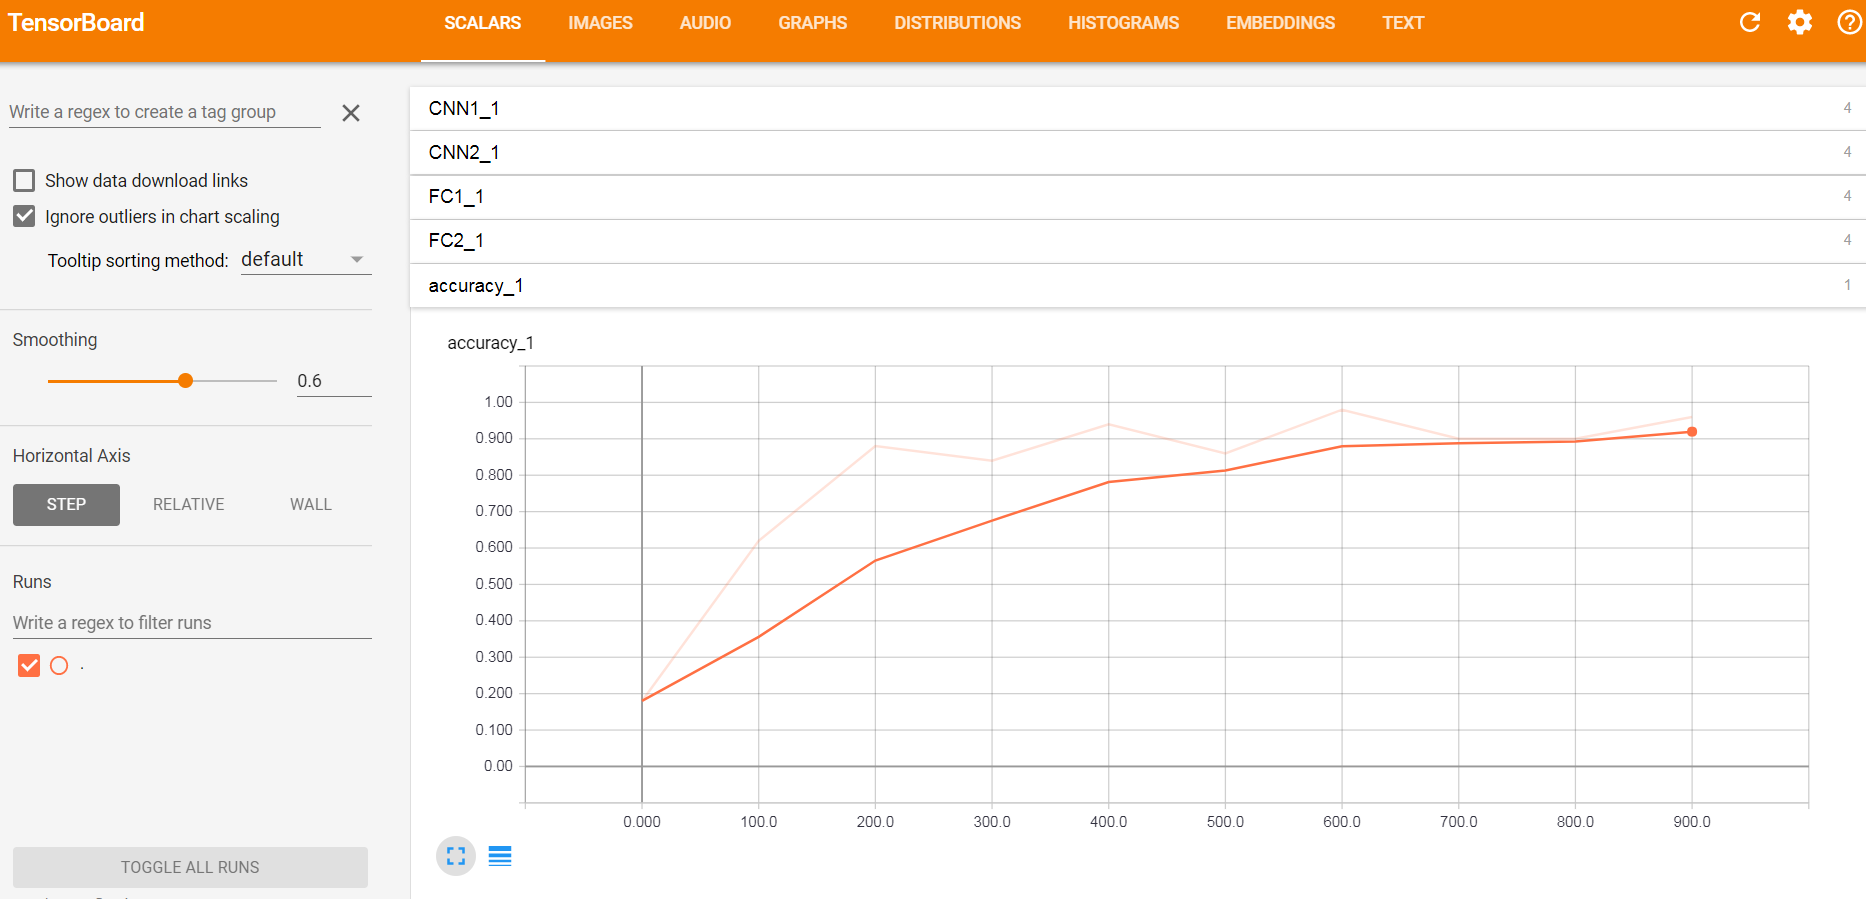

Pretty Cool!!, right? More details of how to interpet these graph can be found here:
https://www.tensorflow.org/get_started/graph_viz